# Project 3: Web APIs & NLP
by Ethan Leow


<div>
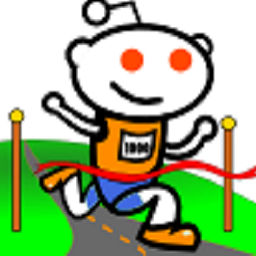
</div>

r/Ultramarathons: "Any idiot can run a marathon. It takes a special kind of idiot to run an ultramarathon."

r/ultrarunning: "Sometimes a marathon isn't far enough"



## Problem statement

I am a newbie to the marathon scene, having completed my first StanChart marathon virtually when the country was locked down during Covid-19 last year. I am itching to do my first ultramarathon (defined as any run beyond 42.195km) and have prepared a series of posts to ask running veterans for training advice. I found two of the most popular reddit communities for the ultra-running community to be r/Ultramarathon and r/ultrarunning. These are some of their attributes:

|subreddit|Date Created|Number of Members|Members Online (at time of checking)|
|---------|------------|-----------------|------------------------------------|
|r\Ultramarathon|Apr 25, 2010|57,000|18 (on 25 Sep, 1500h, SG time)|
|r\ultrarunning|Feb 4, 2012|45,700|40 (on 25 Sep, 1500h, SG time)|

Both communities look quite similar in size. r\Ultramarathon has 25% more members than r\ultrarunning, but the latter has more than twice the number of online (active) members than the former when I checked in at 3pm on 25 Sep. I want to find out where my posts would naturally belong to and elicit the most helpful comments. Their community descriptions are not helpful:
- r/Ultramarathon: Ultramarathon training, race reports, tips, tricks and overall discussion for crazy people who like ultrarunning.
- r/AdvancedRunning: Welcome to ultrarunning.

A quick scan of their recent posts is also not very helpful. Both communities have a lot of posts about how to train for 50k and beyond, as well as other miscellaneous items such as race reports. It is time to deploy my data science skills to come up with an algorithm to decide which running community most suited for my questions...

## Executive summary

Describe both subreddits, e.g. # of users, activity frequency

## Import Libraries

In [3]:
# Import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib_venn import venn2
import seaborn as sns

# Import time- and API- related libraries
import time, requests
from datetime import datetime

# Import warnings to remove flags when project is complete
import warnings
warnings.filterwarnings('ignore')

# Import pre-processing libraries
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from bs4 import BeautifulSoup
import re
# from wordcloud import WordCloud ## Can't seem to install wordcloud, remember to try again at end of project
# from PIL import Image

# Import vectorizing libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Import modelling-related libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix

# Set viewing parameters
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

## Scrap reddit

### Create scrapper function

In [ ]:
# Create scrapper function

def scrape_subreddit(subreddit, numberofposts = 1_000):
    # Define pushshift's base URL
    url = 'https://api.pushshift.io/reddit/search/submission'
    
    # Define columns i want to keep
    to_keep = ['subreddit','author','title','selftext','created_utc']
    
    # Set current time in UTC timestamp format
    df_time = int(datetime.timestamp(datetime.utcnow()))
    
    # Create empty dataframe for concating loop later on
    df = pd.DataFrame(columns = to_keep)
    df_length = len(df)
    
    # Create dataframe of posts
    while df_length < numberofposts:

        # Set params
        params = {
            'subreddit' : subreddit,
            'size' : 100,
            'before' : df_time
        }

        # Get request from pushshift.io, return error message if it is not from 200 series
#         res = requests.get(url, params)
        try:
            res = requests.get(url, params)

            # Return error message if it's not 2xx
            if (res.status_code // 100) != 2:
                return "Hey dude, error! Unexpected response {}".format(res)

        except res.exceptions.RequestException as e:
            # A serious problem happened, like an SSLError or InvalidURL
            return "Yo, this is a very terrible error: {}".format(e)
        
        
        # Concat relevant .json data into dataframe
        df = pd.concat([
            df,
            pd.DataFrame(res.json()['data'])[to_keep]
        ], 
            axis = 0
        )
        
        # Clean data
        ##  1. drop empty posts
        df = df.loc[
            ((df['selftext'] != '') & (df['selftext'] != '[removed]')),
            :
        ].sort_values('created_utc', ascending = False)
        ##  2. drop duplicates by author with same text
        df = df.drop_duplicates(subset=['selftext', 'author'], keep = 'first').reset_index(drop=True)
        ##  3. drop nulls, especially true for selftext column
        df.dropna(inplace = True)
        
        # Find earliest-dated post in dataframe
        df_time = df['created_utc'].min()
#         print(f"min time is {df_time}.")
        
        # Find current length of dataframe (
        df_length = len(df)
        print(f"df for r\\{subreddit} has {df_length} posts now.")
       
        # Be a good citizen of scrapping world, don't overload pushshift server 
        # Sleep between 1-3 seconds
        time.sleep(1 + np.random.rand() * 2)
        
    return df[:numberofposts]
    
    

Describe scrapper function:
- Arguments to feed in are (subreddit, numberofposts)
    - "subreddit" is the name of the target subreddit
    - "numberofposts" is the number of good-quality reddit posts to extract (default value is set at 1_000)
- Set size at 100 for each request for posts
- Dropping bad-quality posts:
    - I notice about 20% of the posts are pictures or videos of people running, with nothing written, i.e. '' in the 'selftext', so those are dropped
    - There are a small number of np.nan posts, those are removed
    - A number of posts seem to be advertisements, they are labeled "[removed]" in the 'selftext' columns, so those are dropped
    - I remove reposts by the same author just in case they are posted more than once
- I set a random sleep time of between 1 to 2 seconds to avoid getting blacklisted by server for repeat requests

### Scrap scrap scrap

> Do not run this section to save time. Jump straight to Section 5.1 to download saved .csv files. Typically takes about 3-10 minutes for me to run, depending on internet connection

To extract 1,500 good-quality posts from each subreddit community. Chosen subreddits are:
- r\Ultramarathon
- r\AdvancedRunning

In [39]:
%%time
# Do not run this section to save time. Jump straight to Section 5.1 to download saved .csv files
# Typically takes about 3-10 minutes for me to run, depending on internet connection

# set scrape parameters
subreddit1 = 'Ultramarathon'
subreddit2 = 'ultrarunning'
posts = 1_500

# scrape from subreddits
df1 = scrape_subreddit(subreddit1, posts)
df2 = scrape_subreddit(subreddit2, posts)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 3.81 µs


In [ ]:
df1

In [ ]:
df2

### Save files to .csv

In [ ]:
# Check for nan
print(f"# of Nulls for df1 \n {df1.isnull().sum()}")
print(f"# of Nulls for df2 \n {df2.isnull().sum()}")

In [ ]:
# Check files that have empty posts or that are '[removed]' by reddit

In [ ]:
df1.loc[((df1.selftext == '[removed]') | (df1.selftext == '')), :]

In [ ]:
df2.loc[((df1.selftext == '[removed]') | (df2.selftext == '')), :]

In [ ]:
# Check for reposts
df1.duplicated().sum(), df2.duplicated().sum()

In [ ]:
# Save files
df1.to_csv('../data/df1.csv', index = False)
df2.to_csv('../data/df2.csv', index = False)

## EDA and pre-processing

### Load data

In [232]:
df1 = pd.read_csv('../data/df1.csv')
df2 = pd.read_csv('../data/df2.csv')

In [233]:
df1.shape, df2.shape

((1500, 5), (1500, 5))

### Check authors
The intent is to look for very prolific authors who might post so much to a subreddit community that a classification model might just innocently fit to a very small group of authors' writing style. 

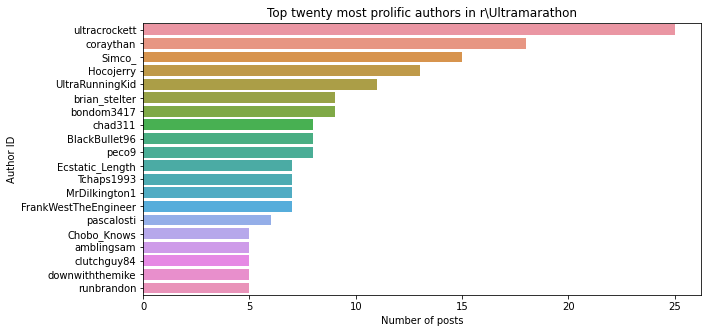

In [234]:
# Rank authors by posts
authors = df1.groupby("author")['selftext'].count().sort_values(ascending = False).head(20)

plt.figure(figsize=(10,5))
ax = sns.barplot(x = authors.values, y = authors.index)
ax.set_title(f"Top twenty most prolific authors in r\\{subreddit1}")
ax.set_xlabel("Number of posts")
ax.set_ylabel("Author ID");

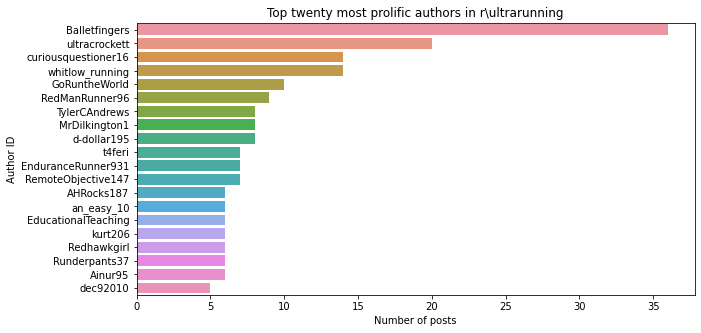

In [235]:
authors = df2.groupby("author")['selftext'].count().sort_values(ascending = False).head(20)

plt.figure(figsize=(10,5))
ax = sns.barplot(x = authors.values, y = authors.index)
ax.set_title(f"Top twenty most prolific authors in r\\{subreddit2}")
ax.set_xlabel("Number of posts")
ax.set_ylabel("Author ID");

It looks like there is no issue with overly-prolific authors on both subreddits. The author with the highest number of posts on r\Ultramarathon is ultracrockett with 25 posts and the author with the highest on r\ultrarunning is Balletfingers with 36 posts. They make up <=3% of their sample sets respectively. 

* However, I notice that ultracrockett is the second largest contributor on r\ultrarunning. This might pose a bit of problem during the modeling stage, as his posts might cause high correlation between the two subreddits. As a robustness check, I will remove his posts at the end of the project to see if its makes a material difference in predictive accuracy.

In [236]:
# Check posts written by AutoModerator
# pd.set_option('display.max_colwidth', None) #Expand Pandas' column width to show full thread content 
# df2[df2['author'] == "AutoModerator"]

[Only relevant if i pick r\\AdvanceRunning]: It looks like 'AutoModerator' is a bot that automatically generates posts to keep readers interested or engaged on events happening in the running world. I shall drop its posts since we are interested in analysing human-generated posts only. These posts make up <0.5% of the sample set.

In [237]:
# # Drop AutoModerator
# df1 = df1[df1['author'] != "AutoModerator"]
# df2 = df2[df2['author'] != "AutoModerator"]

In [238]:
# # Check
# df1[df1['author'] == "AutoModerator"], df2[df2['author'] == "AutoModerator"]

### Check dates

In [239]:
# Check time range of df1
print(f"The start date of df1 is {datetime.fromtimestamp(df1.created_utc.min())}.")
print(f"The end date of df1 is {datetime.fromtimestamp(df1.created_utc.max())}.")

The start date of df1 is 2016-11-14 22:04:29.
The end date of df1 is 2021-09-25 10:39:49.


In [240]:
# Check time range of df2
print(f"The start date of df2 is {datetime.fromtimestamp(df2.created_utc.min())}.")
print(f"The end date of df2 is {datetime.fromtimestamp(df2.created_utc.max())}.")

The start date of df2 is 2020-08-16 06:21:01.
The end date of df2 is 2021-09-25 12:01:52.


r\Ultramarathon has a wider date range than r\ultrarunning. Let's check the distribution of their post dates.

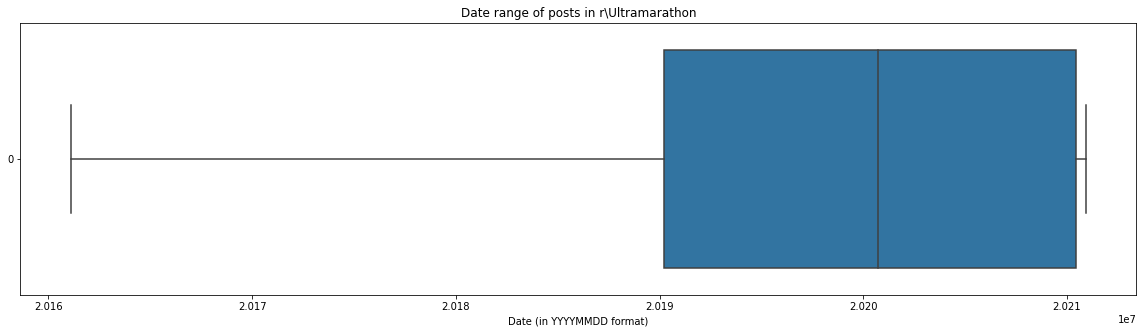

In [241]:
# Convert UTC time to yyyymmdd format, and plot date range
plt.figure(figsize = (20,5))

ax = sns.boxplot(
    data= [int(datetime.utcfromtimestamp(x).strftime("%Y%m%d")) for x in df1.created_utc],
    orient = "h",
)

ax.set_title(f"Date range of posts in r\\{subreddit1}")
ax.set_xlabel("Date (in YYYYMMDD format)");

While r\Ultramarathon has a 5 year date range for its posts, most of them are concentrated in the 2019-2021 range, so they are still quite recent. The 2019-2021 posts are also quite uniformly distributed around the median post. 

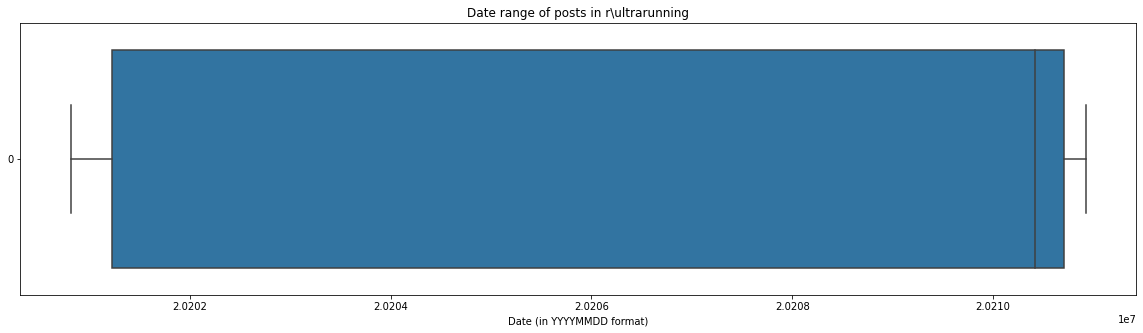

In [242]:
# Convert UTC time to yyyymmdd format, and plot date range
plt.figure(figsize = (20,5))

ax = sns.boxplot(
    data= [int(datetime.utcfromtimestamp(x).strftime("%Y%m%d")) for x in df2.created_utc],
    orient = "h",
)

ax.set_title(f"Date range of posts in r\\{subreddit2}")
ax.set_xlabel("Date (in YYYYMMDD format)");

No surprises here, as all of r\ultrarunning's posts are in 2020 and 2021. The only insight here is that this community is quite active recently, with the median post tilted to 2021.

r\ultrarunning clearly seems to be a more popular or active subreddit. However, less active does not mean worse, as the quality of posts may be more important. We shall move on to check on post length characteristics.

### Check low word count posts

In [243]:
df = pd.concat([df1, df2], axis = 0).reset_index(drop=True)
df['word_count'] = df['selftext'].map(lambda x: len(x.split()))

In [244]:
df.groupby('subreddit').agg({'word_count': ['min', 'median', 'mean', 'max']})

word_count                         
                     min median        mean   max
subreddit                                        
Ultramarathon          1   90.0  155.422000  3720
ultrarunning           1   93.0  139.589333  2663

The median post in r\Ultramarathon is slightly shorter than r\ultrarunning, but the mean word count is higher, so it suggests that some writers in the latter community write very long posts, perhaps ultracrockett!

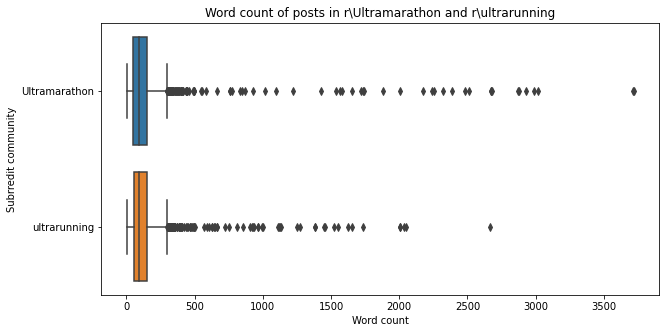

In [245]:
plt.figure(figsize = (10,5))
ax = sns.boxplot(data = df, 
                 x = "word_count", 
                 y = "subreddit",
                 orient = "h",
);

ax.set_title(f"Word count of posts in r\\{subreddit1} and r\\{subreddit2}")
ax.set_xlabel("Word count");
ax.set_ylabel("Subrredit community");

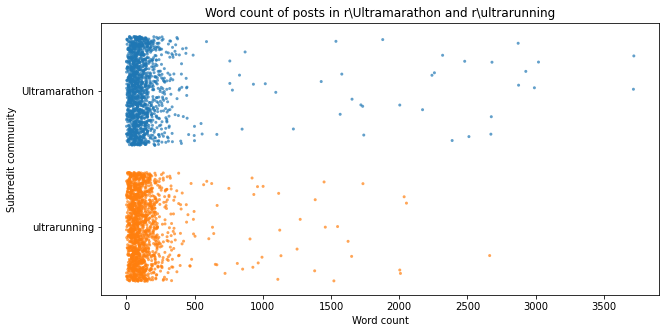

In [246]:
plt.figure(figsize = (10,5))
ax = sns.stripplot(data = df,
                   x = "word_count", 
                   y = "subreddit",
                   size = 3,
                   alpha = 0.7,
                   jitter = 0.4
                   
                
);

ax.set_title(f"Word count of posts in r\\{subreddit1} and r\\{subreddit2}")
ax.set_xlabel("Word count");
ax.set_ylabel("Subrredit community");

Box plots and strip plots suggest that writers in r\Ultramarathon write more than those in r\ultrarunning, with quite a number of them writing essay-length posts of over 2000 words!!
However, I do not see big material differences between the two communities of runners that will pose an obstacle to my problem statement.

In the groupby table above, I notice that the minimum number of words is 1. Let's analyse posts with low word counts to see if they are useful for my model. I start with a random sample of posts with 5 words or less.

In [247]:
# Count the number of posts with low word count
for i in range(1,6):
    print(f"There are {len(df[df['word_count'] == i])} posts of word count length = {i}.")

There are 15 posts of word count length = 1.
There are 4 posts of word count length = 2.
There are 3 posts of word count length = 3.
There are 5 posts of word count length = 4.
There are 10 posts of word count length = 5.


In [248]:
# Increase column width to view post contents
pd.set_option('display.max_colwidth', None)

In [249]:
# Sample posts with low word counts to see if they are useful
df.loc[df['word_count'] <= 5, :].sample(5)

,subreddit,author,title,selftext,created_utc,word_count
673,Ultramarathon,cbskiddies,Does anyone know a 100 miler single loop or point to point going on west of Kansas in November or December?,Looking for recommendations!,1602532095,3
1305,Ultramarathon,ElHalcon,"My Aldi is featuring a Crane brand ultra-type hydration vest next week. Bladder not included, but...",[Hydration type vest at Aldi.](https://www.aldi.us/en/weekly-specials/aldi-finds-for-may-16/may-16-detail/ps/p/crane-bike-or-sport-backpack-2/),1525894175,5
297,Ultramarathon,edgar_allen_snatch69,How many miles per week should you average in order to run a race that is 100+ miles?,\n\n[View Poll](https://www.reddit.com/poll/nh3r87),1621525873,2
2031,ultrarunning,curiousquestioner16,Longest long run before first 50 mi?,\n\n[View Poll](https://www.reddit.com/poll/nv1kcr),1623150688,2
505,Ultramarathon,King_falcon-113,Would you rather,Ok thx\n\n[View Poll](https://www.reddit.com/poll/lfn8a8),1612822028,4


It looks like vast majority of low word count posts are urls. Some are obvious spams, such as "love stream is at:..." These will be handled at the pre-processing stage.
Some are post of run timings, which may be relevant or useful information to readers and will be kept.

### Total word count
<a id='word_count_1'></a>

In [250]:
# Count starting number of words
print(f"Before pre-processing, I start with {df['word_count'].sum()} words in my dataset.")

Before pre-processing, I start with 442517 words in my dataset.


### Remove URLs

In [251]:
# Remove all text with "http" in it
df['cleaned_1'] = df['selftext'].map(
    lambda x: re.sub(r'http\S+', '', x)
)

In [252]:
# Sample to check rows with URLs orginally
df.loc[['http' in x for x in df['selftext']],['selftext','cleaned_1']].sample(2)

,selftext,cleaned_1
708,"Hi guys. We're really grateful to those who have already contributed to our research! Our Ph.D team at the University of Limerick, Ireland, are exploring the sleep patterns and smartphone usage of fitness enthusiasts aged 18-24. We are particularly interested in hearing from users of devices with sleep tracking capability (e.g. Fitbit, Garmin). If you would like to contribute to this study, please click on the link below to complete a 15-minute questionnaire. Thanks so much for your time guys!\n\n[https://micquality.qualtrics.com/jfe/form/SV\_bJX3oVH6i9V4UxT](https://micquality.qualtrics.com/jfe/form/SV_bJX3oVH6i9V4UxT)\n\nInformation on the background to this study is available in this paper which we published in early 2020:\n\nMac Cárthaigh, S., Griffin, C., &amp; Perry, J. (2020). The relationship between sleep and problematic smartphone use among adolescents: A systematic review. *Developmental Review*, *55*, 100897.","Hi guys. We're really grateful to those who have already contributed to our research! Our Ph.D team at the University of Limerick, Ireland, are exploring the sleep patterns and smartphone usage of fitness enthusiasts aged 18-24. We are particularly interested in hearing from users of devices with sleep tracking capability (e.g. Fitbit, Garmin). If you would like to contribute to this study, please click on the link below to complete a 15-minute questionnaire. Thanks so much for your time guys!\n\n[\n\nInformation on the background to this study is available in this paper which we published in early 2020:\n\nMac Cárthaigh, S., Griffin, C., &amp; Perry, J. (2020). The relationship between sleep and problematic smartphone use among adolescents: A systematic review. *Developmental Review*, *55*, 100897."
309,"Last summer, I ran the 272 mile Long Trail in Vermont self-supported. With the help of Pilot Field, we were able to put together a 15 minute documentary for free on YouTube. Check it out and let me know what you think!\n\n[https://www.youtube.com/watch?v=Ydq-WFHk7CE](https://www.youtube.com/watch?v=Ydq-WFHk7CE)","Last summer, I ran the 272 mile Long Trail in Vermont self-supported. With the help of Pilot Field, we were able to put together a 15 minute documentary for free on YouTube. Check it out and let me know what you think!\n\n["


In [253]:
# Refresh word count column
#   and check posts with low word count again
df['word_count'] = df['cleaned_1'].map(lambda x: len(x.split()))

for i in range(1,6):
    print(f"There are {len(df[df['word_count'] == i])} posts of word count length = {i}.")

There are 11 posts of word count length = 1.
There are 2 posts of word count length = 2.
There are 3 posts of word count length = 3.
There are 8 posts of word count length = 4.
There are 7 posts of word count length = 5.


### Check low word count posts again

There are just a handful of posts with 2 words or less. These might be the remnants of those posts that mainly most links to videos or other websites. Let's check them out.

In [254]:
# Sample posts with 2 word counts or less
df.loc[df['word_count'] <= 2, ['author','title','cleaned_1']]

,author,title,cleaned_1
219,mcdishy,Sabrina Verjee smashes Wainright round record!,
297,edgar_allen_snatch69,How many miles per week should you average in order to run a race that is 100+ miles?,\n\n[View Poll](
479,[deleted],Sleepiness,[deleted]
553,ExerciseThoughtStudy,We are a group of researchers at Rutgers University who are conducting a research study about thoughts and emotions during exercise. See the flyer for more information and to take our prescreen survey.,[\n\n
598,EubieDubieBlake,Desert Solstice is live on Youtube right now,
631,PooQuiche,"Hayden Hawks at the JFK50, bloody 'ell! Strava link below...",[
1203,clutchguy84,"Race report from Indiana Trail, 2018",[
1244,ThinkingTooHardAbouT,Ultrarunning in a nutshell: Two years ago during a 40M race I got stung eight times in the head by hornets and won. This year I got stung in the crotch. PB.,#beetoo
1294,tararunstheworld,Transylvania 50k Ultra was intense. I would recommend it for those that like pain.,[
1509,MuiMui888,Banning Vitamin I in UTMB. Seems a bit overreaching,


To delete all of the above posts, they are not written in proper English and won't contribute in training my model in predicting posts.

In [255]:
# Delete cleaned posts with 2 words or less
df = df.loc[df['word_count'] >2,:]
# Check
df.shape

(2981, 7)

In [256]:
# Check posts with 3 words
df.loc[df['word_count'] == 3, ['author','title','cleaned_1']]

,author,title,cleaned_1
506,King_falcon-113,Wyrr,Chose\n\n[View Poll](
673,cbskiddies,Does anyone know a 100 miler single loop or point to point going on west of Kansas in November or December?,Looking for recommendations!
686,SGF2YT,Ksjjs,Die die dieee


In [257]:
# Check posts with 4 words
df.loc[df['word_count'] == 4, ['subreddit','author','title','cleaned_1']]

,subreddit,author,title,cleaned_1
206,Ultramarathon,mcdishy,The UK’s Top 10 Ultramarathons,In one guys opinion! \n\n
505,Ultramarathon,King_falcon-113,Would you rather,Ok thx\n\n[View Poll](
810,Ultramarathon,Ultramarathoner,2020 Barkley Marathons Cancelled,Jamil Coury announced it.
893,Ultramarathon,bigtasty2019,What you pack (food/prep/first aid) for a 50K,Show me your goodies
1330,Ultramarathon,Dantoo2008,Peter Attila,How to achieve UM?
1443,Ultramarathon,Johnnytheknife,"For anyone interested, Comrades marathon starts in less than two hours...",Love stream is at:
1948,ultrarunning,mcdishy,The Top 10 UK Ultra’s,In one guys opinion! \n\n
2158,ultrarunning,MountainRunner911,Thoughts on ultrarunners using cannabis for recovery or just in general during training blocks?,Just curious about this.


In [258]:
# Check posts with 5 words
df.loc[df['word_count'] == 5, ['subreddit','author','title','cleaned_1']]

,subreddit,author,title,cleaned_1
556,Ultramarathon,MrDilkington1,"So how many 50's, 100k's and 75/80 mers did you do before running 100 miles?",Just trying to build perspective
761,Ultramarathon,optimisticpessimist5,What are some good 50 miles this year that have not been cancelled?,If there are any left.
974,Ultramarathon,05778,Why Not Kill This Subreddit?,And merge it with r/ultrarunning?
1077,Ultramarathon,Rogue_Artichoke,How do you all stretch daily?,Asking for a friend. :)
1305,Ultramarathon,ElHalcon,"My Aldi is featuring a Crane brand ultra-type hydration vest next week. Bladder not included, but...",[Hydration type vest at Aldi.](
2437,ultrarunning,adriannairda,Is someone here doing the 4-4-48 challenge?,Any recommendations? Much appreciate it!
2902,ultrarunning,exiveres,Racing?,Are any states allowing ultras?


After deleting posts with 2 or less words, I analyse posts with 3-5 words. 

It is clear that the longer the posts, the more relevant they are to running:
* Those with 3 words are irrelevant and will be killed off.
* Those with 4 words are less relevant so it should be okay killing it. For example, one has a message called "love stream is at:" while another author named mcdishy posted the same message on both subreddits giving his opinion of the top 10 ultramarathons in the UK.
* The posts with 5 words are somewhat relevant to running, so I shall keep them. Including one asking for r/Ultramarathon to be killed or merged with r/ultrarunning! Looks like I am not the only one feeling frustrated by two similar subreddit communities!!


In [259]:
# Remove posts with 3 and 4 words, retain only posts with 5 words and above

df = df.loc[df['word_count'] >= 5,:].reset_index(drop=True)
# Check
df.shape

(2970, 7)

A total of 30 mostly-irrelevant posts (== 1% of the original posts) are removed.

### Remove special characters

In [260]:
# Look at cleaned samples again
df[['subreddit','title','cleaned_1']].sample(5)

subreddit  \
2603   ultrarunning   
2809   ultrarunning   
714   Ultramarathon   
678   Ultramarathon   
1040  Ultramarathon   

                                                                  title  \
2603                                                   How to reach 50k   
2809                                            Zion 100 miler question   
714                                 My 100-Miler Plan: Feedback Wanted!   
678                                Early Death Valley runs in the 1960s   
1040  I am now an ultra marathoner - 50k Armstrong Redwoods - finished!   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

Ran through a number of samples. Manually remove "\n", "\\" , "[]", "()", "|", "-", "&amp;#x200B". Because these subreddits are running-related, it is probably not a good idea to remove numbers as they are usually related to distances or timings. I will probably submitting numbers in my own posts to the subreddits too!

I also notice a lot of "ultras" and "ultramarathons" mentioned on both subreddits, so mental reminder to myself to include them as stop words.

In [261]:
# Replace specials characters
# df['cleaned_2'] = df['cleaned_1'].map(
#     lambda x: re.sub(r'[\n\\\[\]\(\)\|\-]', ' ', x)
# )

# Remove the %ampersand term
df['cleaned_2'] = df['cleaned_1'].map(
    lambda x: x.replace('&amp;#x200B;', ' ') 
)

# Extract words only    
df['cleaned_2'] = df['cleaned_2'].map(
    lambda x: re.sub('[^a-zA-Z]', ' ', x)
)


In [262]:
# Check for removal of special characters
df[['cleaned_1','cleaned_2']].sample(5)

,cleaned_1,cleaned_2
232,"I've signed up for my first 50k in which will take place the first week of September. I have a solid training *i think* and good foundational miles already as I average 35-45 miles weekly. The race route has minimal elevation changes and I'm already comfortable with running in the humid climate because its a local race and I run in this climate years round. I'm super excited and nervous about getting into this so I want to try to make sure I'm as prepared as I can be which is why Im looking for advice.\n\nI don't have a good cross training routine at all, and the training plan calls for two days of core work, so any advice for a solid core routine would be greatly appreciated. But I'm also looking for any general tips for the race and/or preparation that I wouldn't think of or just things you wish you had know going into your first race. What things should I make sure I have with me on the day of?",I ve signed up for my first k in which will take place the first week of September I have a solid training i think and good foundational miles already as I average miles weekly The race route has minimal elevation changes and I m already comfortable with running in the humid climate because its a local race and I run in this climate years round I m super excited and nervous about getting into this so I want to try to make sure I m as prepared as I can be which is why Im looking for advice I don t have a good cross training routine at all and the training plan calls for two days of core work so any advice for a solid core routine would be greatly appreciated But I m also looking for any general tips for the race and or preparation that I wouldn t think of or just things you wish you had know going into your first race What things should I make sure I have with me on the day of
712,"This topic is for all of you that have already experienced the 24h race. I've read a lot about run/walk strategies, but my question is how you test each one. Do you try after your long runs (ex: 3h running and then 1h testing you approach), do you use specific sessions for it on double days or any other approach?\n\n \nThank you!",This topic is for all of you that have already experienced the h race I ve read a lot about run walk strategies but my question is how you test each one Do you try after your long runs ex h running and then h testing you approach do you use specific sessions for it on double days or any other approach Thank you
1229,"Looks like he's racing Leadville! [\n\nHe's won 4 50k's this year, so I imagine is he in great shape to at least be at or near the podium.",Looks like he s racing Leadville He s won k s this year so I imagine is he in great shape to at least be at or near the podium
2555,"I'm in my hometown, which is surrounded by gorgeous farmland, and I'd love to take advantage of my time here with a daylong jaunt tomorrow, but I intend to attempt my second-ever un/self-supported solo 100 in mid-Jan, also departing from my hometown, with a goal of finishing under 24 hours.\n\nDo you think the 40 would seriously interfere with reaching my goal on the 100 if I take it very easy? Basically looking for people to talk sense into me if this is a ridiculous plan.",I m in my hometown which is surrounded by gorgeous farmland and I d love to take advantage of my time here with a daylong jaunt tomorrow but I intend to attempt my second ever un self supported solo in mid Jan also departing from my hometown with a goal of finishing under hours Do you think the would seriously interfere with reaching my goal on the if I take it very easy Basically looking for people to talk sense into me if this is a ridiculous plan
254,So I signed up for my first ultra this year! I was training for it pretty hard putting in 60-70km per a week ramping up to 90km. This was hard on my body and not sustainable. How did you change training when your run was cancelled?,So I signed up for my first ultra this year I was training for it pretty 

A few rounds of sampling shows that the cleaning looks fine.

### Check sentiment

I am curious to find out the general sentiment of writers in these two subreddits, want to see if there is a discernible difference between each community. I use the VADER (Valence Aware Dictionary and sEntiment Reasoner) lexicon to analyze the sentiments of our posts.

In [263]:
# Create sentiment column
sent = SentimentIntensityAnalyzer()
df['sentiment'] = df['cleaned_2'].map(lambda x: sent.polarity_scores(x)['compound'])

In [264]:
# Check sentiment
df.groupby('subreddit').agg({'sentiment': ['min', 'median', 'mean', 'max']})

sentiment                           
                    min   median      mean     max
subreddit                                         
Ultramarathon   -0.9979  0.69045  0.495699  0.9999
ultrarunning    -0.9969  0.69080  0.460766  0.9997

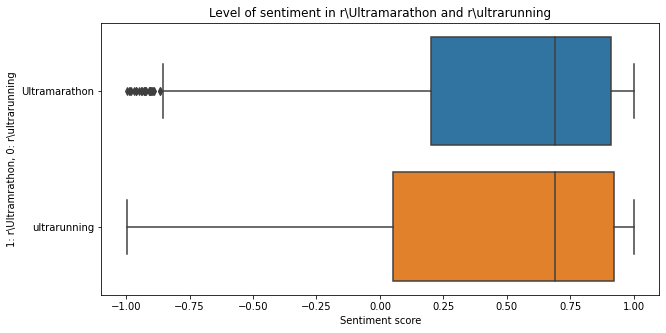

In [265]:
plt.figure(figsize = (10,5))
ax = sns.boxplot(data = df, 
                 x = "sentiment", 
                 y = "subreddit",
                 orient = "h",
);

ax.set_title(f"Level of sentiment in r\\{subreddit1} and r\\{subreddit2}")
ax.set_xlabel("Sentiment score");
ax.set_ylabel("1: r\\Ultramrathon, 0: r\\ultrarunning");

The median runner-author seems to be a very positive person, with a score of 0.7 for both subreddits. The mean score is much lower for both communities, dragged down by a number of neutral and negative posts. I cannot discern a material difference between posts in the two subreddit communities based on VADER sentiment analysis.

### Tokenize words

I shall make all words lower case and split by blank spaces.

In [266]:
# Tokenizing...
df['cleaned_3'] = df['cleaned_2'].map(lambda x: x.lower().split())
# Check
df[['cleaned_1','cleaned_2','cleaned_3']].sample(5)

,cleaned_1,cleaned_2,cleaned_3
2026,"I’ve started running with my dog and am looking to upgrade his leash, collar etc. what kind of harness do you use?",I ve started running with my dog and am looking to upgrade his leash collar etc what kind of harness do you use,"[i, ve, started, running, with, my, dog, and, am, looking, to, upgrade, his, leash, collar, etc, what, kind, of, harness, do, you, use]"
2513,"I just read his book and feel like I have a good grasp of the training principles. While understanding each athlete is different and requires different specific training, I'm having a hard time figuring out how to write the Endurance Run phase leading up to a race with all the generalities given about this phase.\n\nSo that leaves me wondering what guiding principles I should follow for writing this phase. How do I know if I'm getting enough volume to finish the race? I'm working toward a 50 mile A race.\n\nI know the min/max he gives for this distance is 6 hours for 3 weeks. But that honestly seems insanely low to me. haha. \n\nAny tips or advice would be most appreciated! :)",I just read his book and feel like I have a good grasp of the training principles While understanding each athlete is different and requires different specific training I m having a hard time figuring out how to write the Endurance Run phase leading up to a race with all the generalities given about this phase So that leaves me wondering what guiding principles I should follow for writing this phase How do I know if I m getting enough volume to finish the race I m working toward a mile A race I know the min max he gives for this distance is hours for weeks But that honestly seems insanely low to me haha Any tips or advice would be most appreciated,"[i, just, read, his, book, and, feel, like, i, have, a, good, grasp, of, the, training, principles, while, understanding, each, athlete, is, different, and, requires, different, specific, training, i, m, having, a, hard, time, figuring, out, how, to, write, the, endurance, run, phase, leading, up, to, a, race, with, all, the, generalities, given, about, this, phase, so, that, leaves, me, wondering, what, guiding, principles, i, should, follow, for, writing, this, phase, how, do, i, know, if, i, m, getting, enough, volume, to, finish, the, race, i, m, working, toward, a, mile, a, race, i, know, the, min, max, he, gives, ...]"
1765,"Watched some Salomon videos earlier and Candice appeared in the Tahoe 200 video, featuring Courtney. Am I hearing things or does she kinda have an accent? Can't really figure out what accent tho.",Watched some Salomon videos earlier and Candice appeared in the Tahoe video featuring Courtney Am I hearing things or does she kinda have an accent Can t really figure out what accent tho,"[watched, some, salomon, videos, earlier, and, candice, appeared, in, the, tahoe, video, featuring, courtney, am, i, hearing, things, or, does, she, kinda, have, an, accent, can, t, really, figure, out, what, accent, tho]"
1965,"Anyone here in the New England area have feedback on how a presi-traverse run compares to any ultra's out there? I'm considering getting into ultra trail running but my longest race is a half marathon and my longest hike has been the presi-traverse (one way). The traverse killed me and we only did around 23 miles with 9,000 ft of Vert. can't imagine a 50 miler or 100 miler with even more vert.\n\nAny feedback would be cool.",Anyone here in the New England area have feedback on how a presi traverse run compares to any ultra s out there I m considering getting into ultra trail running but my longest race is a half marathon and my longest hike has been the presi traverse one way The traverse killed me and we only did around miles with ft of Vert can t imagine a miler or miler with even more vert Any feedback would be cool,"[anyone, here, in, the, new, england, area, have, feedback, on, how, a, presi, traverse, run, compares, to, any, ultra, s, out, there, i, m, considering, getting

In [267]:
# Count total number of words again
np.sum([len(x) for x in df['cleaned_3']])

441190

After cleaning and splitting, I actually end up with more words in total (444,833) than my [initial naive word count](#word_count_1) of 442,751.

### Common words, create stop words

I shall first look at word frequency and conduct a few iterations of different "stop words".

In [268]:
# Create function to analyse top 20 most frequently used words 
#   with defined stop-words dictionary 
def frequentwords(data, column_name = None, stopwords = None, n = 1):
    cvec = CountVectorizer(
        stop_words = stopwords,   # Default is no stop words
        ngram_range = (n,n)      # Default is to analyze 1-gram only
    )
    
    # Create word vector on subreddit1 
    vector1 = cvec.fit_transform(
        data.loc[
            data['subreddit'] == subreddit1,
            column_name
        ]
    )
    vector1_df = pd.DataFrame(
        vector1.todense(),
        columns = cvec.get_feature_names()
    ).sum(
    ).sort_values(
        ascending = False
    )
#     print(vector1_df)
    
    # Create word vector on subreddit2
    vector2 = cvec.fit_transform(
        data.loc[
            data['subreddit'] == subreddit2,
            column_name
        ]
    )
    vector2_df = pd.DataFrame(
        vector2.todense(),
        columns = cvec.get_feature_names()
    ).sum(
    ).sort_values(
        ascending = False
    )
#     print(vector2_df)
    
    # Prepare subplot area
    fig, axes = plt.subplots(figsize = (10,15), nrows = 3, ncols = 1)
    
    # Plot top 20 most common words
    ax1 = sns.barplot(
        x = vector1_df.head(20).values,
        y = vector1_df.head(20).index,
        orient = 'h',
        ax = axes[0]
    )
    ax1.set_title(f"Top 20 most common words for r\\{subreddit1}")
    ax1.set_xlabel("Frequency")
    ax1.set_ylabel("Words");
    
    ax2 = sns.barplot(
        x = vector2_df.head(20).values,
        y = vector2_df.head(20).index,
        orient = 'h',
        ax = axes[1]
    )
    ax2.set_title(f"Top 20 most common words for r\\{subreddit2}")
    ax2.set_xlabel("Frequency")
    ax2.set_ylabel("Words");
    
    # Plot Venn diagram to check intersection of 50 most common words
    ax3 = venn2(
        [
            set(vector1_df.head(50).index),
            set(vector2_df.head(50).index)
        ],
        set_labels = (f'r\\{subreddit1}', f'r\\{subreddit2}')
    )
    plt.title('Top 50 words in posts')
    plt.tight_layout()

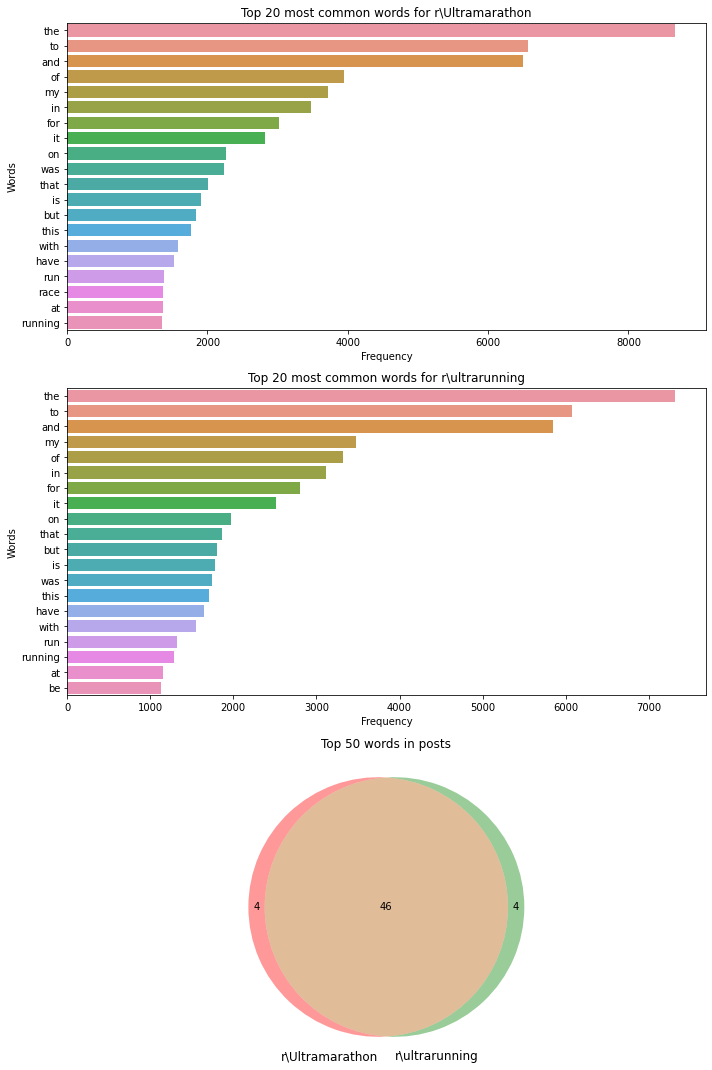

In [269]:
# Check most frequent words for subreddits
frequentwords(df, 'cleaned_2')

Both subreddits have almost exactly the same common words! That doesn't bode well for differentiating between subreddits. I shall apply NLTK's default stop word dictionary and see if anything changes.

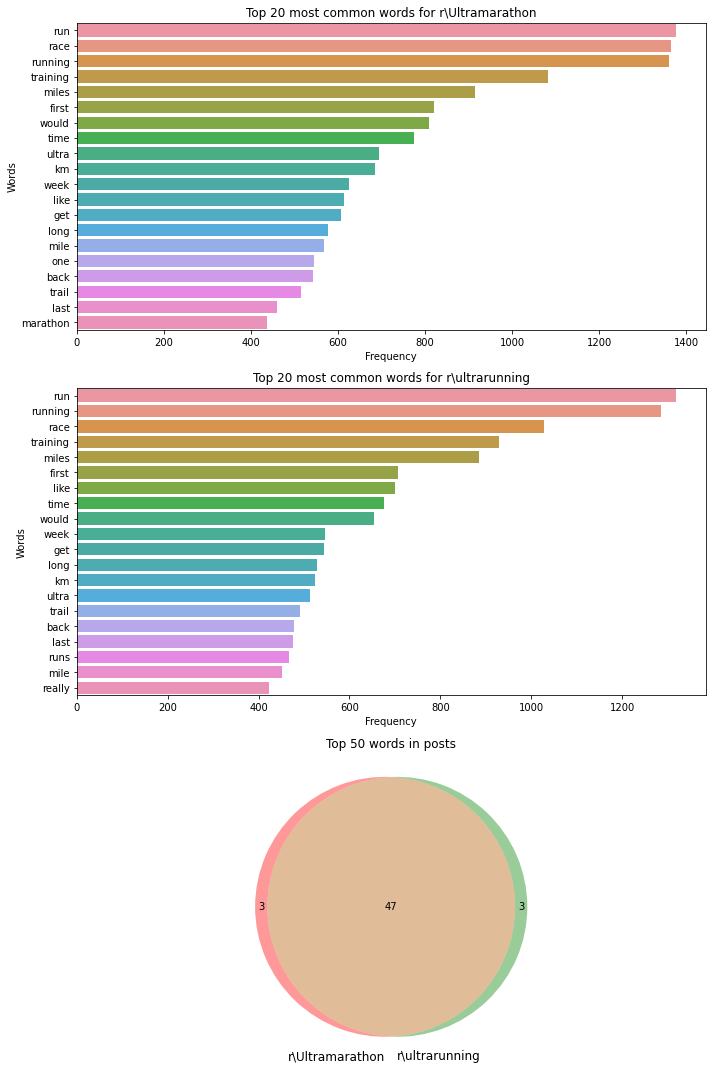

In [270]:
# Apply nltk stop words
words_to_remove = stopwords.words('english')

# Check most frequent words after stop word removal
frequentwords(df, 'cleaned_2', words_to_remove)

Looking better now. Here are some additional words to remove in the next round:
- Remove "ultramarathon", "ultramarathons", "ultrarunning" from both subreddits, to avoid giving the model an unfair advantage since the purpose is to figure out if a post should belong to r\Ultramarathon or r\ultrarunning
- Remove common running words such as "run", "running", "race", "training", "miles", "mile"

In [271]:
# Round 3: Expand stop word dictionary
words_to_remove += ["ultramarathon", "ultramarathons", "ultrarunning"]
words_to_remove += ["run", "running", "race", "training", "miles", "mile"]

In [272]:
# Check last few words in dict
words_to_remove[-20:]

["shan't",
 'shouldn',
 "shouldn't",
 'wasn',
 "wasn't",
 'weren',
 "weren't",
 'won',
 "won't",
 'wouldn',
 "wouldn't",
 'ultramarathon',
 'ultramarathons',
 'ultrarunning',
 'run',
 'running',
 'race',
 'training',
 'miles',
 'mile']

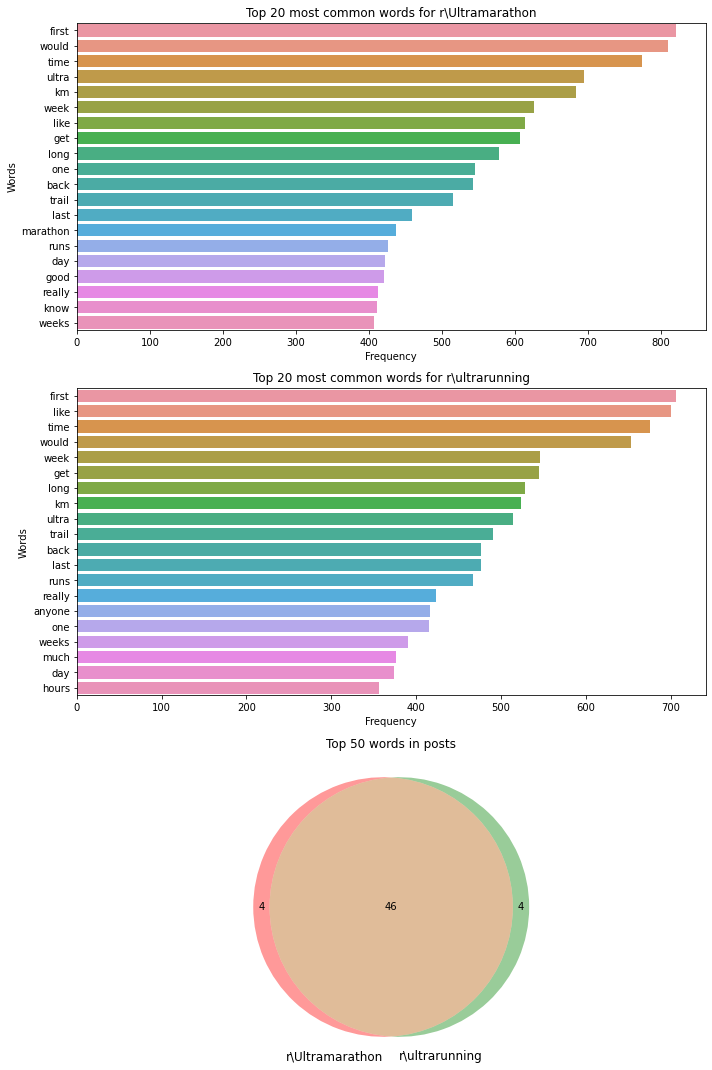

In [273]:
# Check most frequent words after additional stop words 
frequentwords(df, 'cleaned_2', words_to_remove)

The most frequently used words are starting to look more different between the two subreddits but still a lot of similarities. Still looking like an uphill task for my classification model later. Let's look at bigrams and trigrams now.

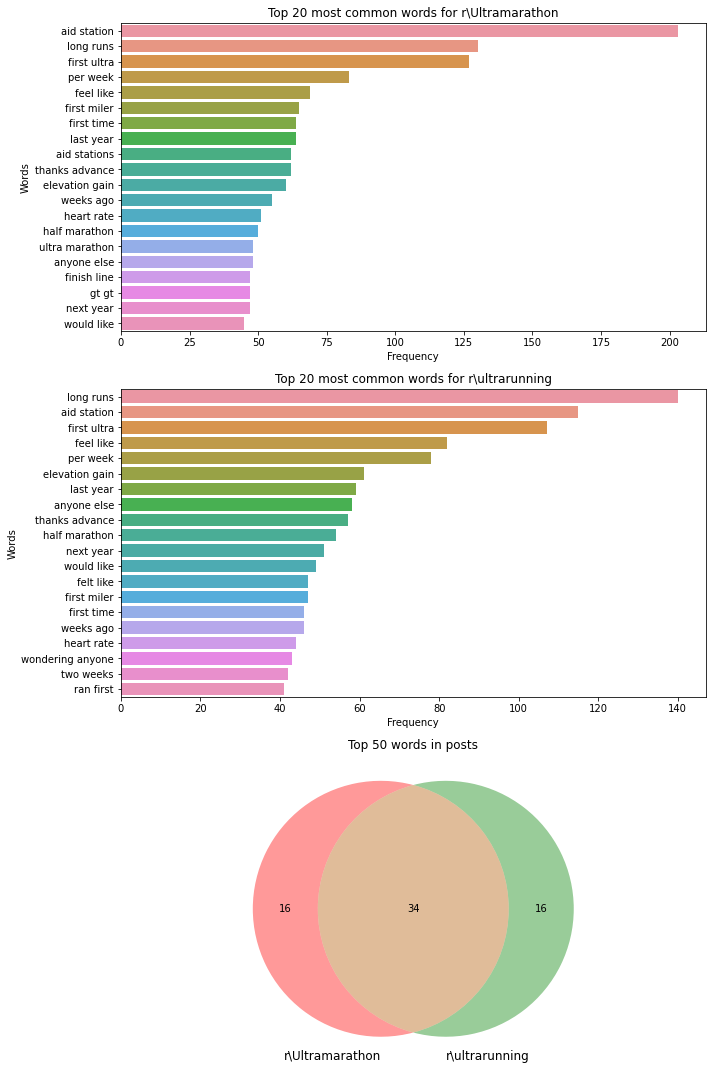

In [274]:
# Analyze bi-grams in subreddits
frequentwords(df, 'cleaned_2', words_to_remove, 2)

Bi-grams for both subreddits are also quite similar. Classificatio model won't be easy to train well...

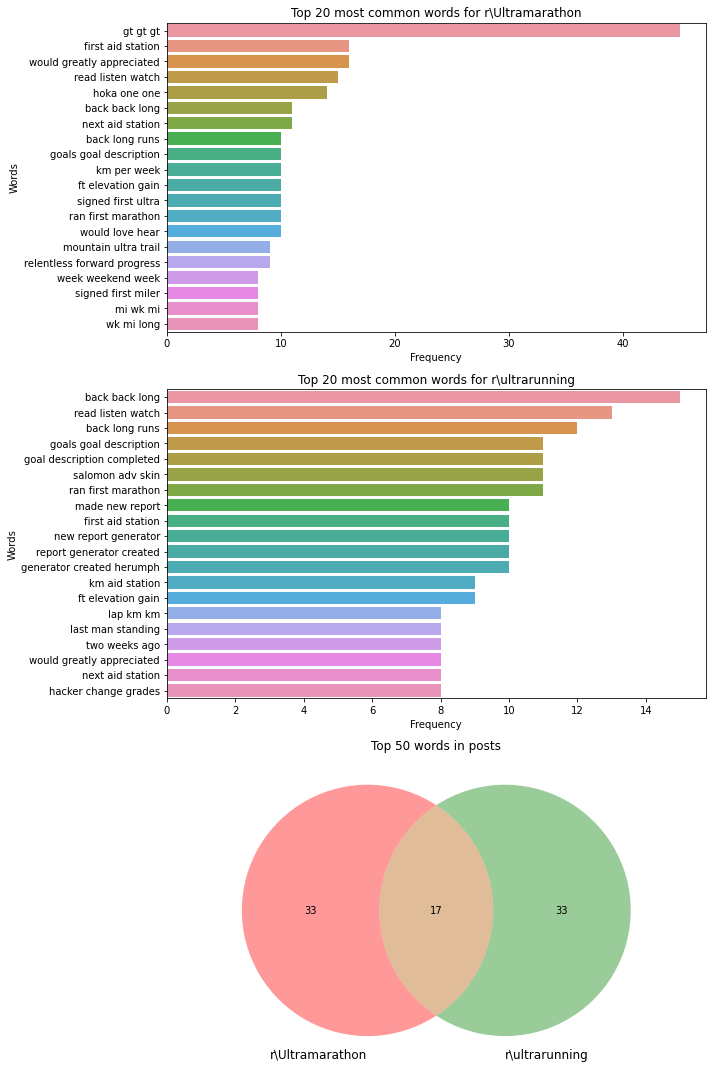

In [275]:
# Analyze tri-grams in subredditsa
frequentwords(df, 'cleaned_2', words_to_remove, 3)

I can see more differentiation in tri-grams coming from the two subreddit communities, but the actual frequency (<20) is not that high, so might be difficult for the classification model to pick up and train on.

In [276]:
### Venn Diagram

### Lemmatize and stemmatize

Next step is to lemmatize the word tokens.

In [277]:
# Lemmatize after removing stop words
lemmatizer = WordNetLemmatizer()

df['cleaned_lemma'] = df['cleaned_3'].map(
    lambda x: [lemmatizer.lemmatize(token) \
               for token in x \
               if token not in words_to_remove]
).map(
    lambda x: ' '.join(x)
)

In [278]:
# Check
df[['cleaned_2', 'cleaned_lemma']].sample(5)

,cleaned_2,cleaned_lemma
527,As someone who s done a couple of Ultras I ve started to realize the act of running miles isn t really what I come out for anymore Its more to hang out with the awesome folks you train race pace crew with The Ultra community is really special and I just hate that connection has been basically closed down by COVID,someone done couple ultras started realize act really come anymore hang awesome folk train pace crew ultra community really special hate connection basically closed covid
234,I m not new to ultras but I ve got my first hour race coming up soon mile laps of a flat course Whilst I ve been out that long and longer before I m aiming to give myself as much or an advantage as I can and I m very aware of how different a format it is to what I normally do usually undulating or mountainous ultras But I ve the vague notion that I might try and be competitive if I m not totally outclassed on the day I m not currently overthinking my pacing I tend to go by feel and push towards the end and I don t have the brain space for a conscious run walk strategy My plan is just to keep moving and keep my lowest speed relatively high fast power hike and run as much as I m able to Fuelling is pretty tried and tested but I m planning to have different options in case it s hot and the usual stuff isn t doing it for me I m planning to take ml of water per lap on the course with me to save needing a vest it s only a small event so I m hoping queues for top ups will be minimal Are there any tips anyone can share particularly around around the different approaches needed compared to normal ultras,new ultras got first hour coming soon lap flat course whilst long longer aiming give much advantage aware different format normally usually undulating mountainous ultras vague notion might try competitive totally outclassed day currently overthinking pacing tend go feel push towards end brain space conscious walk strategy plan keep moving keep lowest speed relatively high fast power hike much able fuelling pretty tried tested planning different option case hot usual stuff planning take ml water per lap course save needing vest small event hoping queue top ups minimal tip anyone share particularly around around different approach needed compared normal ultras
1772,So I m a bit of a novice when it comes to ultras only done a few ks I ve been running for several years now all as a hobbyist never ran in school or anything like that I ve never been coached I m interested in zone training I ve never really done it all my training has been by perceived effort I follow the general advice of the rule try to keep myself st conversational pace most of the time Can someone do an ELI on zone training or suggest any good resources Suggestions on a good heart rate monitor would be much appreciated as well Ill try to circle back and answer any questions soon Thanks,bit novice come ultras done k several year hobbyist never ran school anything like never coached interested zone never really done perceived effort follow general advice rule try keep st conversational pace time someone eli zone suggest good resource suggestion good heart rate monitor would much appreciated well ill try circle back answer question soon thanks
602,So I have never run an ultra before but now I m hooked Post race I was shocked of how good I felt My knees were definitely very sore for about a week but aside from that I felt pretty good After the race I took off about days completely from running and working out general aside form some lite calisthenics on day Ran three times in week two of recovery of distances between three to five miles I ran today miles at what felt like a very easy pace but my watch which has a heart rate monitor in it said that I was pushing into zone Even though it s a heart rate monitor in the watch it s traditionally relatively accurate compared to my chest strap I didn t feel like I was pushing myself but my question is Does it take a while bef

Next, I apply [Porter's stemmer](https://www.cs.toronto.edu/~frank/csc2501/Readings/R2_Porter/Porter-1980.pdf) to return the base form of words. It tends to be cruder than using lemmatization only, so I shall check out both methods to see which works better.

In [279]:
# Stemmatize after removing stop words
stemmer = PorterStemmer()

df['cleaned_stemmer'] = df['cleaned_3'].map(
    lambda x: [stemmer.stem(token) \
               for token in x \
               if token not in words_to_remove]
).map(
    lambda x: ' '.join(x)
)

In [280]:
# Check
df[['cleaned_3', 'cleaned_lemma', 'cleaned_stemmer']].sample(5)

,cleaned_3,cleaned_lemma,cleaned_stemmer
1724,"[how, long, do, a, lot, of, your, running, packs, vests, last, i, ve, had, two, different, packs, and, they, have, lasted, me, two, very, different, lengths, of, time, my, osprey, aura, has, seen, pretty, hard, us, for, years, between, all, my, long, runs, and, races, it, s, held, up, really, well, some, of, the, materials, in, the, shoulder, straps, are, just, starting, to, fail, but, otherwise, it, s, been, a, great, well, designed, pack, my, raidlight, lazerdry, is, a, different, story, i, ve, only, ran, with, the, lazerdry, this, season, and, mostly, on, my, long, runs, it, s, got, some, ...]",long lot pack vest last two different pack lasted two different length time osprey aura seen pretty hard u year long run race held really well material shoulder strap starting fail otherwise great well designed pack raidlight lazerdry different story ran lazerdry season mostly long run got pretty bad design issue water bladder sleeve main compartment started tear put sleeve first time difficult get refill stuff tends fall side pocket side pocket also starting tear bottom zipper starting fail picked pack clearance longer sold u durable pack got wild rugged miler three week considering getting larger average pack would folk recommend,long lot pack vest last two differ pack last two differ length time osprey aura seen pretti hard us year long run race held realli well materi shoulder strap start fail otherwis great well design pack raidlight lazerdri differ stori ran lazerdri season mostli long run got pretti bad design issu water bladder sleev main compart start tear put sleev first time difficult get refil stuff tend fall side pocket side pocket also start tear bottom zipper start fail pick pack clearanc longer sold us durabl pack got wild rug miler three week consid get larger averag pack would folk recommend
2027,"[hellooooo, i, ve, been, running, with, a, very, minimalist, salomon, l, vest, for, the, last, few, years, and, want, to, upgrade, get, a, larger, one, i, will, still, use, the, tiny, vest, for, lt, mi, runs, but, want, something, large, enough, bottles, bladder, for, all, day, missions, year, round, in, montana, multiple, layers, food, traction, aids, etc, but, comfy, minimalist, enough, that, it, doesn, t, feel, like, mad, overkill, taking, out, for, hours, either, i, m, looking, at, the, nathan, pinnacle, l, and, want, to, know, y, all, s, experience, with, it, so, love, it, meh, pros, cons, other, suggestions, ...]",hellooooo minimalist salomon l vest last year want upgrade get larger one still use tiny vest lt mi run want something large enough bottle bladder day mission year round montana multiple layer food traction aid etc comfy minimalist enough feel like mad overkill taking hour either looking nathan pinnacle l want know experience love meh pro con suggestion l way much gotten pretty good fitting essential l know need least bit room ultras horizon pinnacle appealing tried salomon lab series find feel constrictive underneath arm fwiw thought go ud store nathan way comfortable,hellooooo minimalist salomon l vest last year want upgrad get larger one still use tini vest lt mi run want someth larg enough bottl bladder day mission year round montana multipl layer food traction aid etc comfi minimalist enough feel like mad overkil take hour either look nathan pinnacl l want know experi love meh pro con suggest l way much gotten pretti good fit essenti l know need least bit room ultra horizon pinnacl appeal tri salomon lab seri find feel constrict underneath arm fwiw thought go ud store nathan way comfort
1064,"[asking, for, a, friend]",asking friend,ask friend
296,"[i, dnf, d, my, last, miler, because, my, ankle, gave, out, at, mile, the, ankle, is, held, together, by, steel, plates, does, anyone, else, have, steel, plates, and, still, have, success, running, s, i, have, another, in, weeks, my, ankle, doesn, t, feel, the, strongest, and, i, m, nervous, anyone, have, thought

Stemmer looks terrible...but hey, it might work better! Let's see in the next section.

### Total word count again

In [281]:
# Count total number of words in lemmatized posts and stemmatized posts
print(f"The original total word count is {df['word_count'].sum()}.")
print(f"Total word count after lemmatization is {np.sum([len(x.split()) for x in df['cleaned_lemma']])}.")
print(f"Total word count after stemmatization is {np.sum([len(x.split()) for x in df['cleaned_stemmer']])}.")

The original total word count is 442257.
Total word count after lemmatization is 203806.
Total word count after stemmatization is 203806.


In [282]:
df.shape

(2970, 12)

In [283]:
234327 / 442257 -1

-0.47015649271803495

To summarize, after data pre-processing, a total of 30 rows (1% of original) are removed, and about 47% of the words in posts are remove.

### Remove other special characters??

## Modeling

### Binarize subreddit column

I set r\Ultramarathon as "1" and r\ultrarunning as "0".

In [284]:
# Binarize
df['subreddit'] = df['subreddit'].map({'Ultramarathon' : 1,
                                       'ultrarunning' : 0})
# Check
df

,subreddit,author,title,selftext,created_utc,word_count,cleaned_1,cleaned_2,sentiment,cleaned_3,cleaned_lemma,cleaned_stemmer
0,1,tizawer,MCM 50k Sale,Purchased registration for the Marine Corps Marathon 50k (sold out). Looking to transfer to another runner - message me for more details.,1632537589,22,Purchased registration for the Marine Corps Marathon 50k (sold out). Looking to transfer to another runner - message me for more details.,Purchased registration for the Marine Corps Marathon k sold out Looking to transfer to another runner message me for more details,0.0000,"[purchased, registration, for, the, marine, corps, marathon, k, sold, out, looking, to, transfer, to, another, runner, message, me, for, more, details]",purchased registration marine corp marathon k sold looking transfer another runner message detail,purchas registr marin corp marathon k sold look transfer anoth runner messag detail
1,1,lazysl0b,What’s your baseline MPW and schedule?,"I’ve done a couple of ultras now and want to build slowly up to a 100 miler (and hopefully more after that…). I’ve researched some training plans for the weeks leading up to the race, but curious what others experience is of building to &amp; staying in shape for ultras.\n\nDo you just keep mileage high and build the base? Hold constant and then add more hills / speed work? Take longer breaks after a race then do a 12-16 week training plan?",1632472993,83,"I’ve done a couple of ultras now and want to build slowly up to a 100 miler (and hopefully more after that…). I’ve researched some training plans for the weeks leading up to the race, but curious what others experience is of building to &amp; staying in shape for ultras.\n\nDo you just keep mileage high and build the base? Hold constant and then add more hills / speed work? Take longer breaks after a race then do a 12-16 week training plan?",I ve done a couple of ultras now and want to build slowly up to a miler and hopefully more after that I ve researched some training plans for the weeks leading up to the race but curious what others experience is of building to amp staying in shape for ultras Do you just keep mileage high and build the base Hold constant and then add more hills speed work Take longer breaks after a race then do a week training plan,0.6059,"[i, ve, done, a, couple, of, ultras, now, and, want, to, build, slowly, up, to, a, miler, and, hopefully, more, after, that, i, ve, researched, some, training, plans, for, the, weeks, leading, up, to, the, race, but, curious, what, others, experience, is, of, building, to, amp, staying, in, shape, for, ultras, do, you, just, keep, mileage, high, and, build, the, base, hold, constant, and, then, add, more, hills, speed, work, take, longer, breaks, after, a, race, then, do, a, week, training, plan]",done couple ultras want build slowly miler hopefully researched plan week leading curious others experience building amp staying shape ultras keep mileage high build base hold constant add hill speed work take longer break week plan,done coupl ultra want build slowli miler hope research plan week lead curiou other experi build amp stay shape ultra keep mileag high build base hold constant add hill speed work take longer break week plan
2,1,ultracrockett,Spartathlon,"Spartathlon (246 km/153 miles) starts tomorrow for the 38th year in Greece on an ancient route run by Pheidippides in 490 B.C. In 1982, John Foden and other British airmen proved that this route from Athens to Sparta could be run in less than two days. This was the birth of Spartathlon! \n\nFor the first time, this historic 1982 Royal Air Force (RAF) Expedition story is told in detail. The runners were aided and paced by young students and teachers from an English school in Athens, and faced challenges of heat, hunger, thirst, dogs, gunshot, and getting lost continually, but three made it.\n\nRead/Listen/Watch [https://ultrarunninghistory.com/spartathlon-1/](https://ultrarunninghistory.com/spartathlon-1/?fbclid=IwAR

### Baseline score

In [285]:
# Check baseline score
df.subreddit.value_counts(normalize = True)

0    0.50101
1    0.49899
Name: subreddit, dtype: float64

The baseline score to beat is 50.1%

### Check data again

In [286]:
# Check nulls
df.isnull().sum()

subreddit          0
author             0
title              0
selftext           0
created_utc        0
word_count         0
cleaned_1          0
cleaned_2          0
sentiment          0
cleaned_3          0
cleaned_lemma      0
cleaned_stemmer    0
dtype: int64

In [287]:
# Check split of target data
df['subreddit'].value_counts(normalize = True)

0    0.50101
1    0.49899
Name: subreddit, dtype: float64

### Create train test sets

In [288]:
# Create train test sets
X = df['cleaned_lemma']
y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify = y,
    random_state = 42
)

In [289]:
# Check
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2227,), (743,), (2227,), (743,))

### Create custom function

I create a custom function that automates a few steps:
* Instantiate a GridSearchCV
* Fit on train set
* Create confusion matrix on test set
* Print results of best parameters, best score, train score, test score and various confusion matrix metrics

In [303]:
# Create function to run pipe and print results
def run_grid(X_train, X_test, y_train, y_test):
    # Instantiate GridSearchCV
    gs = GridSearchCV(
        pipe, 
        param_grid = params, 
        n_jobs= -1, 
        cv=5)

    # Fit model
    gs.fit(X_train, y_train)

    # Confusion matrix
    y_pred = gs.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Print results
    print(f'Best Score is {gs.best_score_:.3f}')
    print('Best Parameters are:', gs.best_params_)
    print(f'Train score is: {gs.score(X_train, y_train):.3f}')
    print(f'Test score (aka Accuracy): {gs.score(X_test, y_test):.3f}')
    print(f'Sensitivity: {tp/(tp+fn):.3f}, Specificity: {tn/(tn+fp):.3f}, Precision: {tp/(tp+fp):.3f}')

### Parametric models

#### CountVectorizer / Multinomial

In [304]:
%%time
# Make pipe
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

# Set parameters
params = {
    'cvec__min_df': [1, 2],
    'cvec__max_df': [.1, .25, .5, 1],
    'cvec__max_features' : [500, 1000, 2000],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'nb__alpha': [.25, .5, 1]
}

# Run pipe in GridSearchCV and print results
run_grid(X_train, X_test, y_train, y_test)

Best Score is 0.558
Best Parameters are: {'cvec__max_df': 0.5, 'cvec__max_features': 500, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1), 'nb__alpha': 1}
Train score is: {gs.score(X_train, y_train):.3f}
Test score (aka Accuracy): {gs.score(X_test, y_test):.3f}
Sensitivity: 0.485, Specificity: 0.605, Precision: 0.550
CPU times: user 2.38 s, sys: 352 ms, total: 2.74 s
Wall time: 1min 21s


The train score (0.65) is much higher than test score (0.55), so this is a sign of overfitting. The test score isn't too far away from the train set's cross_val_score (0.56) so this model is quite disappointing.

Try Term Frequency-Inverse Document Frequency (TF-IDF) Vectorizer as there are too many common words acorss all posts and between subreddits. This method will attempt to give more weight to words that occur often in one document but don't occur in many documents, hopefully this can create more predictive power in my model.

#### TfidfVectorizer / Multinomial

In [298]:
%%time
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

# Set parameters
params = {
    'tvec__min_df': [1, 2],
    'tvec__max_df': [.1, .25, .5, 1],
    'tvec__max_features' : [500, 1000, 2000],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'nb__alpha': [.25, .5, 1]
}

# Run pipe in GridSearchCV and print results
run_grid(X_train, X_test, y_train, y_test)

Best Params 0.5635531818410844
Best Score: {'nb__alpha': 1, 'tvec__max_df': 0.5, 'tvec__max_features': 500, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 3)}
Train: 0.6748989672204759
Test: 0.5397039030955586
Accuracy: 0.540, Sensitivity: 0.526
Specificity: 0.554, Precision: 0.540
CPU times: user 3.56 s, sys: 441 ms, total: 4 s
Wall time: 1min 30s


#### CountVectorizer / Logistic

In [299]:
%%time
# Make pipe
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('logit', LogisticRegression())
])

# Set parameters
params = {
    'cvec__min_df': [1, 2],
    'cvec__max_df': [.1, .25, .5, 1],
    'cvec__max_features' : [500, 1000, 2000],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'logit__C': [0.1, 1, 10],
    'logit__max_iter': [1_000]
}

# Run pipe in GridSearchCV and print results
run_grid(X_train, X_test, y_train, y_test)

Best Params 0.5523182344938781
Best Score: {'cvec__max_df': 0.5, 'cvec__max_features': 1000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1), 'logit__C': 0.1, 'logit__max_iter': 1000}
Train: 0.7831162999550966
Test: 0.5289367429340511
Accuracy: 0.529, Sensitivity: 0.531
Specificity: 0.527, Precision: 0.528
CPU times: user 2.65 s, sys: 416 ms, total: 3.06 s
Wall time: 1min 43s


#### TfidfVectorizer / Logistic

In [300]:
%%time
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logit', LogisticRegression())
])

# Set parameters
params = {
    'tvec__min_df': [1, 2],
    'tvec__max_df': [.1, .25, .5, 1],
    'tvec__max_features' : [500, 1000, 2000],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'logit__C': [0.1, 1, 10],
    'logit__max_iter': [1_000]
}

# Run pipe in GridSearchCV and print results
run_grid(X_train, X_test, y_train, y_test)

Best Params 0.573416637275155
Best Score: {'logit__C': 0.1, 'logit__max_iter': 1000, 'tvec__max_df': 0.5, 'tvec__max_features': 1000, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 2)}
Train: 0.7031881454872025
Test: 0.5329744279946165
Accuracy: 0.533, Sensitivity: 0.485
Specificity: 0.581, Precision: 0.536
CPU times: user 3.1 s, sys: 424 ms, total: 3.53 s
Wall time: 1min 33s


#### Create model tracking table

### Try stemmer

### Try without unigram

### Extreme removal of intersection words

## Remove ultracrokett

## Join Title to Selftext

In [301]:
pip install matplotlib-venn


Note: you may need to restart the kernel to use updated packages.
